<a href="https://colab.research.google.com/github/Milham10/PracticeML/blob/main/PCB_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection

In this tutorial, you will learn:
- the basic structure of Faster R-CNN.
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 839.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.9.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch=

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile   
path = '/content/drive/MyDrive/PCB_TXT.zip'     
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [6]:
!python /content/VOC_PCB/generate_txt.py

In [5]:
from mmcv import collect_env
collect_env()

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


{'sys.platform': 'linux',
 'Python': '3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla T4',
 'CUDA_HOME': '/usr/local/cuda',
 'NVCC': 'Cuda compilation tools, release 11.2, V11.2.152',
 'GCC': 'x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_

In [7]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.28.1
11.1
GCC 7.3


## Perform Inference with An MMDet detector



In [8]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget --no-check-certificate -c https://download.openmmlab.com/mmdetection/v2.0/resnest/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco_20200926_125502-20289c16.pth\
      -O checkpoints/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco_20200926_125502-20289c16.pth

--2023-02-09 06:03:58--  https://download.openmmlab.com/mmdetection/v2.0/resnest/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco_20200926_125502-20289c16.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.82.212, 163.181.82.219, 163.181.82.216, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.82.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180327820 (172M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco_20200926_125502-20289c16.pth’

checkpoints/faster_ 100%[===================>] 171.97M  74.6MB/s    in 2.3s    

2023-02-09 06:04:00 (74.6 MB/s) - ‘checkpoints/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco_20200926_125502-20289c16.pth’ saved [180327820/180327820]



## Train A Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. Reorganize the dataset into a COCO format.
  2. Reorganize the dataset into a middle format.
  3. Implement a new dataset.

We recommend the first two methods, as they are usually easier than the third one.

In this tutorial, we give an example that converts the data into the formats of existing datasets, e.g. COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/customize_dataset.html#).

First, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but with 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of the dataset.

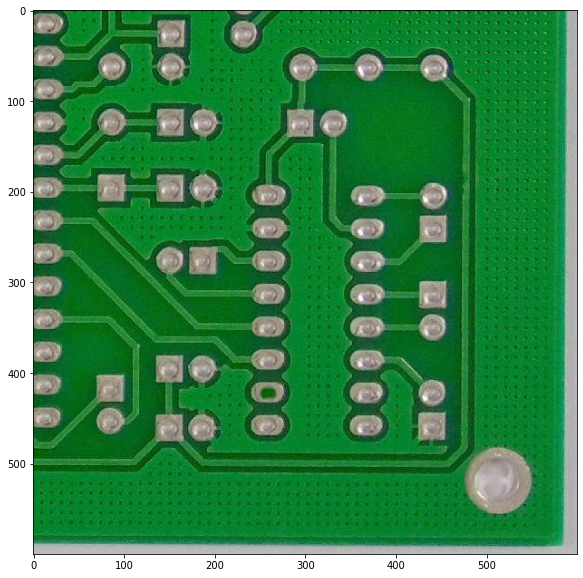

In [9]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/VOC_PCB/JPEGImages/l_light_01_missing_hole_01_1_600.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the KITTI annotation format into the middle format. In this tutorial, we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a look at the annotation txt file.



In [10]:
# Check the label of a single image
!cat /content/VOC_PCB/Annotations_txt/l_light_01_missing_hole_01_1_600.txt

missing_hole 0.00 0 0.0 240.00 404.00 282.00 437.00 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicate the bboxes. We need to read annotations of each image and convert them into middle format that MMDetection can accept, as follows:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4) in (x1, y1, x2, y2) order,
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [11]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('JPEGImages', 'Annotations_txt')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [18]:
from mmcv import Config
cfg = Config.fromfile('./configs/resnest/faster_rcnn_s50_fpn_syncbn-backbone+head_mstrain-range_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset. We modify the config of datasets, learning rate schedules, and runtime settings.

In [19]:
from mmdet.apis import set_random_seed

from mmdet.apis import set_random_seed
# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = '/content/VOC_PCB'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = '/content/VOC_PCB'
cfg.data.test.ann_file = '/content/VOC_PCB/ImageSets/Main/test.txt'
cfg.data.test.img_prefix = '/content/VOC_PCB/JPEGImages'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = '/content/VOC_PCB'
cfg.data.train.ann_file = '/content/VOC_PCB/ImageSets/Main/train.txt'
cfg.data.train.img_prefix = '/content/VOC_PCB/JPEGImages'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = '/content/VOC_PCB'
cfg.data.val.ann_file = '/content/VOC_PCB/ImageSets/Main/val.txt'
cfg.data.val.img_prefix = '/content/VOC_PCB/JPEGImages'


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 6
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco_20200926_125502-20289c16.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 1

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1


# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.device = 'cuda'
cfg.gpu_ids = range(1)
cfg.runner.max_epochs = 3
# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# replace SyncBN to BN
cfg.norm_cfg = dict(type='BN', requires_grad=True)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNeSt',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='open-mmlab://resnest50'),
        stem_channels=64,
        radix=2,
        reduction_factor=4,
        avg_down_stride=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0

In [20]:
from mmdet.apis import set_random_seed

cfg.model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNeSt',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='open-mmlab://resnest50'),
        stem_channels=64,
        radix=2,
        reduction_factor=4,
        avg_down_stride=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared4Conv1FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=6,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0.0, 0.0, 0.0, 0.0],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0),
            conv_out_channels=256,
            norm_cfg=dict(type='BN', requires_grad=True))),
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=-1,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.5,
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=False,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            pos_weight=-1,
            debug=False)),
    test_cfg=dict(
        rpn=dict(
            nms_pre=1000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100)))
dataset_type = 'KittiTinyDataset'
data_root = '/content/VOC_PCB'
img_norm_cfg = dict(
    mean=[123.68, 116.779, 103.939], std=[58.393, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='LoadAnnotations',
        with_bbox=True,
        with_mask=False,
        poly2mask=False),
    dict(
        type='Resize',
        img_scale=[(1333, 640), (1333, 800)],
        multiscale_mode='range',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.68, 116.779, 103.939],
        std=[58.393, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.68, 116.779, 103.939],
                std=[58.393, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='KittiTinyDataset',
        ann_file='/content/VOC_PCB/ImageSets/Main/train.txt',
        img_prefix='/content/VOC_PCB/JPEGImages',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='LoadAnnotations',
                with_bbox=True,
                with_mask=False,
                poly2mask=False),
            dict(
                type='Resize',
                img_scale=[(1333, 640), (1333, 800)],
                multiscale_mode='range',
                keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.68, 116.779, 103.939],
                std=[58.393, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ],
        data_root='/content/VOC_PCB'),
    val=dict(
        type='KittiTinyDataset',
        ann_file='/content/VOC_PCB/ImageSets/Main/val.txt',
        img_prefix='/content/VOC_PCB/JPEGImages',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.68, 116.779, 103.939],
                        std=[58.393, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ],
        data_root='/content/VOC_PCB'),
    test=dict(
        type='KittiTinyDataset',
        ann_file='/content/VOC_PCB/ImageSets/Main/test.txt',
        img_prefix='/content/VOC_PCB/JPEGImages',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.68, 116.779, 103.939],
                        std=[58.393, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ],
        data_root='/content/VOC_PCB'))
evaluation = dict(interval=1, metric='mAP')
optimizer = dict(type='SGD', lr=0.0025, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy='step',
    warmup=None,
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11])
runner = dict(type='EpochBasedRunner', max_epochs=3)
checkpoint_config = dict(interval=1)
log_config = dict(
    interval=1,
    hooks=[dict(type='TextLoggerHook'),
           dict(type='TensorboardLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/faster_rcnn_s50_fpn_syncbn-backbone%2Bhead_mstrain-range_1x_coco_20200926_125502-20289c16.pth'
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
auto_scale_lr = dict(enable=False, base_batch_size=16)
norm_cfg = dict(type='BN', requires_grad=True)
work_dir = './tutorial_exps'
seed = 0
device = 'cuda'
gpu_ids = range(0, 1)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector! We use the high-level API `train_detector` implemented by MMDetection. This is also used in our training scripts. For details of the implementation, please see [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/train.py).

In [21]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

cfg.device='cuda'
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

<ipython-input-11-d30ed5d3c0f3>:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels=np.array(gt_labels, dtype=np.long),
<ipython-input-11-d30ed5d3c0f3>:56: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `n

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3414/3414, 6.6 task/s, elapsed: 518s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-02-09 07:45:08,044 - mmdet - INFO - 
+-----------------+------+------+--------+-------+
| class           | gts  | dets | recall | ap    |
+-----------------+------+------+--------+-------+
| missing_hole    | 1155 | 1242 | 0.995  | 0.991 |
| mouse_bite      | 1131 | 1468 | 0.986  | 0.978 |
| open_circuit    | 1142 | 1612 | 0.989  | 0.976 |
| short           | 1144 | 1422 | 0.949  | 0.890 |
| spur            | 1230 | 1958 | 0.975  | 0.953 |
| spurious_copper | 1165 | 1472 | 0.972  | 0.949 |
+-----------------+------+------+--------+-------+
| mAP             |      |      |        | 0.956 |
+-----------------+------+------+--------+-------+
2023-02-09 07:45:08,231 - mmdet - INFO - Epoch(val) [1][3414]	AP50: 0.9560, mAP: 0.9563
2023-02-09 07:45:11,764 - mmdet - INFO - Epoch [2][1/2560]	lr: 2.500e-03, eta: 1:22:48, time: 3.418, data_time: 2.533, memory: 3913, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0123, loss_cls: 0.0651, acc: 97.0703, loss_bbox: 0.1336, loss: 0.2112
2023-02-09 07:45

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3414/3414, 6.5 task/s, elapsed: 528s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-02-09 08:35:29,867 - mmdet - INFO - 
+-----------------+------+------+--------+-------+
| class           | gts  | dets | recall | ap    |
+-----------------+------+------+--------+-------+
| missing_hole    | 1155 | 1179 | 0.997  | 0.993 |
| mouse_bite      | 1131 | 1268 | 0.995  | 0.991 |
| open_circuit    | 1142 | 1246 | 0.992  | 0.988 |
| short           | 1144 | 1342 | 0.968  | 0.934 |
| spur            | 1230 | 1710 | 0.981  | 0.971 |
| spurious_copper | 1165 | 1823 | 0.988  | 0.967 |
+-----------------+------+------+--------+-------+
| mAP             |      |      |        | 0.974 |
+-----------------+------+------+--------+-------+
2023-02-09 08:35:30,062 - mmdet - INFO - Epoch(val) [2][3414]	AP50: 0.9740, mAP: 0.9741
2023-02-09 08:35:33,346 - mmdet - INFO - Epoch [3][1/2560]	lr: 2.500e-03, eta: 0:41:26, time: 3.173, data_time: 2.312, memory: 3913, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0084, loss_cls: 0.0536, acc: 97.7539, loss_bbox: 0.1292, loss: 0.1919
2023-02-09 08:35

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3414/3414, 6.4 task/s, elapsed: 532s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-02-09 09:26:06,978 - mmdet - INFO - 
+-----------------+------+------+--------+-------+
| class           | gts  | dets | recall | ap    |
+-----------------+------+------+--------+-------+
| missing_hole    | 1155 | 1223 | 0.997  | 0.991 |
| mouse_bite      | 1131 | 1305 | 0.998  | 0.995 |
| open_circuit    | 1142 | 1351 | 0.995  | 0.986 |
| short           | 1144 | 1514 | 0.985  | 0.965 |
| spur            | 1230 | 1458 | 0.992  | 0.986 |
| spurious_copper | 1165 | 1409 | 0.991  | 0.974 |
+-----------------+------+------+--------+-------+
| mAP             |      |      |        | 0.983 |
+-----------------+------+------+--------+-------+
2023-02-09 09:26:07,270 - mmdet - INFO - Epoch(val) [3][3414]	AP50: 0.9830, mAP: 0.9829


### Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

First, since the dataset we are using is small, we loaded a pre-trained Faster R-CNN model and fine-tune it for detection. 
The original Faster R-CNN is trained on COCO dataset that contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layers of the pre-trained Faster R-CNN for classification and regression have different weight shape and are not used.

Second, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 58.1 mAP on the val dataset, not bad!

We can also check the tensorboard to see the curves.

In [ ]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps

From the tensorboard, we can observe that changes of loss and learning rate. We can see the losses of each branch gradually decrease as the training goes by.

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

/content/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


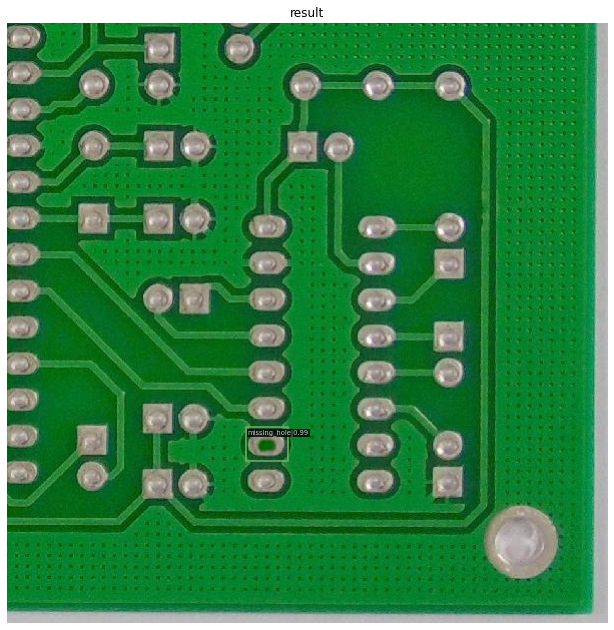

In [22]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

img = mmcv.imread('/content/VOC_PCB/JPEGImages/l_light_01_missing_hole_01_1_600.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


## What to Do Next?

So far, we have learnt how to test and train a two-stage detector using MMDetection. To further explore MMDetection, you could do several other things as shown below:

- Try single-stage detectors, e.g., [RetinaNet](https://github.com/open-mmlab/mmdetection/tree/master/configs/retinanet) and [SSD](https://github.com/open-mmlab/mmdetection/tree/master/configs/ssd) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). Single-stage detectors are more commonly used than two-stage detectors in industry.
- Try anchor-free detectors, e.g., [FCOS](https://github.com/open-mmlab/mmdetection/tree/master/configs/fcos) and [RepPoints](https://github.com/open-mmlab/mmdetection/tree/master/configs/reppoints) in [MMDetection model zoo](https://github.com/open-mmlab/mmdetection/blob/master/docs/en/model_zoo.md). Anchor-free detector is a new trend in the object detection community.
- Try 3D object detection using [MMDetection3D](https://github.com/open-mmlab/mmdetection3d), also one of the OpenMMLab projects. In MMDetection3D, not only can you try all the methods supported in MMDetection but also some 3D object detectors.
